In [3]:
import matplotlib.pyplot as plt

ImportError: dlopen(/Users/andersbarfod/anaconda/lib/python3.6/site-packages/matplotlib/ft2font.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libfreetype.6.dylib
  Referenced from: /Users/andersbarfod/anaconda/lib/python3.6/site-packages/matplotlib/ft2font.cpython-36m-darwin.so
  Reason: Incompatible library version: ft2font.cpython-36m-darwin.so requires version 22.0.0 or later, but libfreetype.6.dylib provides version 21.0.0

In [1]:
from __future__ import division
from itertools import count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
import seaborn as sns
sns.set()
%matplotlib inline

ImportError: dlopen(/Users/andersbarfod/anaconda/lib/python3.6/site-packages/matplotlib/ft2font.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libfreetype.6.dylib
  Referenced from: /Users/andersbarfod/anaconda/lib/python3.6/site-packages/matplotlib/ft2font.cpython-36m-darwin.so
  Reason: Incompatible library version: ft2font.cpython-36m-darwin.so requires version 22.0.0 or later, but libfreetype.6.dylib provides version 21.0.0

In [52]:
def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')


def explain_anomalies(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using stationary standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies

    """
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3), 'anomalies_dict': collections.OrderedDict([(index, y_i) for index, y_i, avg_i in zip(count(), y, avg) if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}


def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = residual.rolling(window_size).std()
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.loc[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3), 'anomalies_dict': collections.OrderedDict([(index, y_i) for index, y_i, avg_i, rs_i in zip(count(), y, avg_list, rolling_std) if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


# This function is repsonsible for displaying how the function performs on the given dataset.
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float, count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

In [62]:
df = pd.read_csv('temp.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
x1 = df.date
y1 = df.tempm

In [19]:
df = df.sort_values(by=['date'])

In [24]:
df.set_index('date', inplace=True)

In [33]:
x = df.reset_index()['date']
y = df.reset_index()['tempm']

In [66]:
df.columns = ['ds', 'y']

In [57]:
explain_anomalies_rolling_std(y, 9)

{'anomalies_dict': OrderedDict([(3, 2),
              (8, 1),
              (9, 1),
              (11, 2),
              (12, 3),
              (13, 3),
              (14, 4),
              (16, 8),
              (17, 8),
              (27, 6),
              (31, 6),
              (32, 6),
              (49, 6),
              (50, 6),
              (51, 6),
              (52, 6),
              (55, 4),
              (56, 3),
              (67, 4),
              (68, 3),
              (73, 3),
              (74, 3),
              (75, 2),
              (76, 2),
              (77, 2),
              (78, 2),
              (79, 2),
              (83, 5),
              (84, 5),
              (85, 5),
              (88, 2),
              (94, 1),
              (101, 1),
              (102, 1),
              (104, 2),
              (105, 3),
              (107, 4),
              (108, 4),
              (112, 4),
              (113, 4),
              (117, 7),
              (123, 7),
         

In [58]:
from fbprophet import Prophet

In [68]:
m = Prophet()
m.fit(df)

/Users/andersbarfod/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [69]:
future = m.make_future_dataframe(periods=365)

In [70]:
future.tail()

,ds
20687,2019-09-29 23:00:00
20688,2019-09-30 23:00:00
20689,2019-10-01 23:00:00
20690,2019-10-02 23:00:00
20691,2019-10-03 23:00:00


In [71]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
20687,2019-09-29 23:00:00,4.911918,-26.181849,39.480893
20688,2019-09-30 23:00:00,4.655200,-26.561238,39.528829
20689,2019-10-01 23:00:00,4.715819,-27.917276,39.204996
20690,2019-10-02 23:00:00,4.632668,-27.704334,39.381783
20691,2019-10-03 23:00:00,4.481341,-27.024298,39.284766


In [75]:
pd.set_option('display.max_columns', 500)

In [77]:
df

,ds,y
0,2016-07-26 00:00:00,19
1,2016-07-26 01:00:00,18
2,2016-07-26 02:00:00,18
3,2016-07-26 03:00:00,18
4,2016-07-26 04:00:00,18
5,2016-07-26 05:00:00,17
6,2016-07-26 06:00:00,17
7,2016-07-26 07:00:00,17
8,2016-07-26 08:00:00,18
9,2016-07-26 09:00:00,18


In [76]:
forecast

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2016-02-01 00:00:00,15.841790,15.841790,15.841790,-0.488125,6.996134,-12.472466,-12.472466,-12.472466,-1.514666,-1.514666,-1.514666,0.0,0.0,0.0,-0.082387,-0.082387,-0.082387,-10.875413,-10.875413,-10.875413,3.369324
1,2016-02-01 01:00:00,15.838092,15.838092,15.838092,-0.772800,6.752662,-12.680029,-12.680029,-12.680029,-1.710394,-1.710394,-1.710394,0.0,0.0,0.0,-0.089520,-0.089520,-0.089520,-10.880115,-10.880115,-10.880115,3.158063
2,2016-02-01 02:00:00,15.834394,15.834394,15.834394,-0.903993,6.659181,-12.848739,-12.848739,-12.848739,-1.867068,-1.867068,-1.867068,0.0,0.0,0.0,-0.096844,-0.096844,-0.096844,-10.884827,-10.884827,-10.884827,2.985655
3,2016-02-01 03:00:00,15.830696,15.830696,15.830696,-1.082957,6.389304,-13.034218,-13.034218,-13.034218,-2.040405,-2.040405,-2.040405,0.0,0.0,0.0,-0.104267,-0.104267,-0.104267,-10.889546,-10.889546,-10.889546,2.796479
4,2016-02-01 04:00:00,15.826998,15.826998,15.826998,-0.859923,6.209904,-13.208600,-13.208600,-13.208600,-2.202634,-2.202634,-2.202634,0.0,0.0,0.0,-0.111691,-0.111691,-0.111691,-10.894275,-10.894275,-10.894275,2.618399
5,2016-02-01 05:00:00,15.823300,15.823300,15.823300,-1.040146,6.335983,-13.273858,-13.273858,-13.273858,-2.255824,-2.255824,-2.255824,0.0,0.0,0.0,-0.119022,-0.119022,-0.119022,-10.899012,-10.899012,-10.899012,2.549443
6,2016-02-01 06:00:00,15.819602,15.819602,15.819602,-1.029897,6.488891,-13.125709,-13.125709,-13.125709,-2.095787,-2.095787,-2.095787,0.0,0.0,0.0,-0.126164,-0.126164,-0.126164,-10.903758,-10.903758,-10.903758,2.693893
7,2016-02-01 07:00:00,15.815904,15.815904,15.815904,-0.587294,7.007564,-12.719216,-12.719216,-12.719216,-1.677678,-1.677678,-1.677678,0.0,0.0,0.0,-0.133026,-0.133026,-0.133026,-10.908512,-10.908512,-10.908512,3.096689
8,2016-02-01 08:00:00,15.812206,15.812206,15.812206,0.285622,7.557853,-12.092115,-12.092115,-12.092115,-1.039325,-1.039325,-1.039325,0.0,0.0,0.0,-0.139515,-0.139515,-0.139515,-10.913275,-10.913275,-10.913275,3.720092
9,2016-02-01 09:00:00,15.808508,15.808508,15.808508,0.568552,8.108850,-11.339704,-11.339704,-11.339704,-0.276112,-0.276112,-0.276112,0.0,0.0,0.0,-0.145547,-0.145547,-0.145547,-10.918045,-10.918045,-10.918045,4.468804


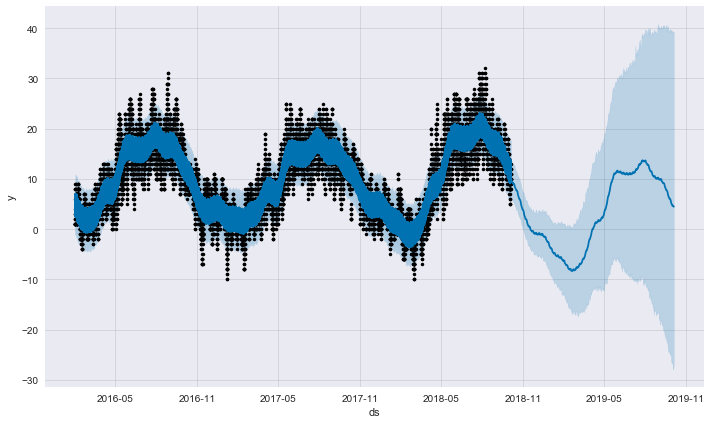

In [72]:
fig1 = m.plot(forecast)

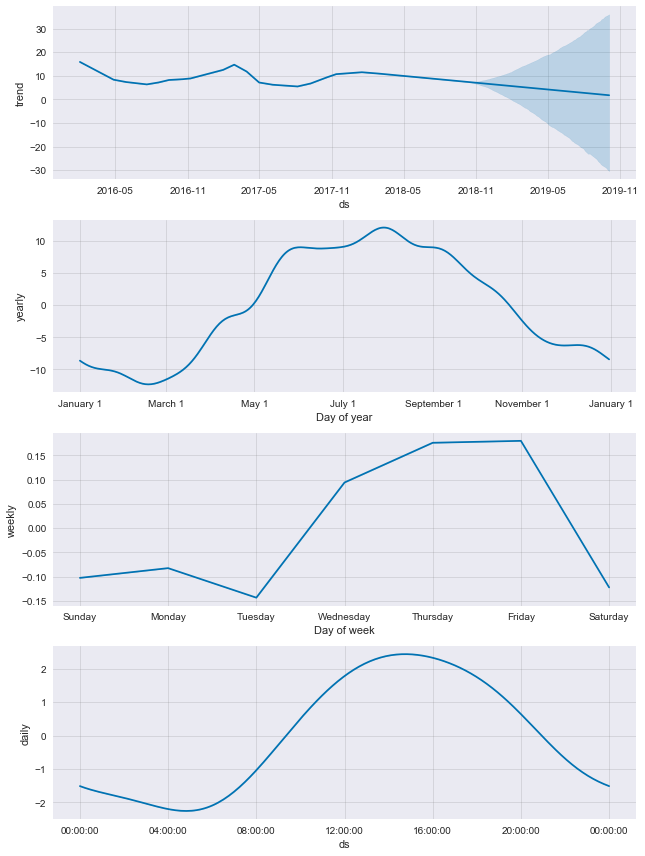

In [73]:
fig2 = m.plot_components(forecast)